In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import numpy as np
# Read the CSV file
df = pd.read_csv('logs/system_evaluation/Roboflow_dataset_V4/detailed_results.csv')


In [194]:
# Convert string representations of dictionaries to actual dictionaries
df['face_detection'] = df['face_detection'].apply(eval)
df['feature_extraction'] = df['feature_extraction'].apply(eval)
df['state_classification'] = df['state_classification'].apply(eval)
df['decision'] = df['decision'].apply(eval)

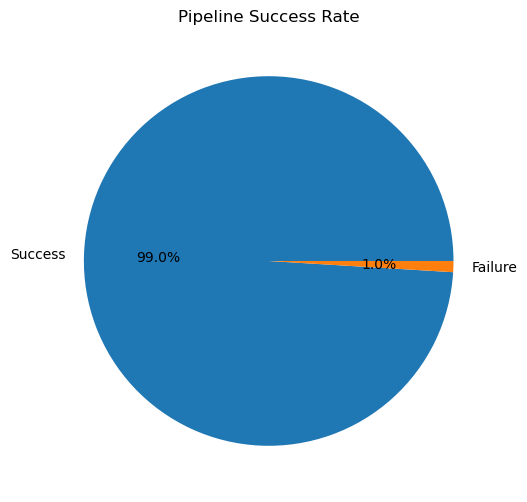

In [195]:
# 1. Overall Pipeline Success Analysis
plt.figure(figsize=(10, 6))
success_counts = df['pipeline_success'].value_counts()
plt.pie(success_counts, labels=['Success', 'Failure'], autopct='%1.1f%%')
plt.title('Pipeline Success Rate')
plt.show()

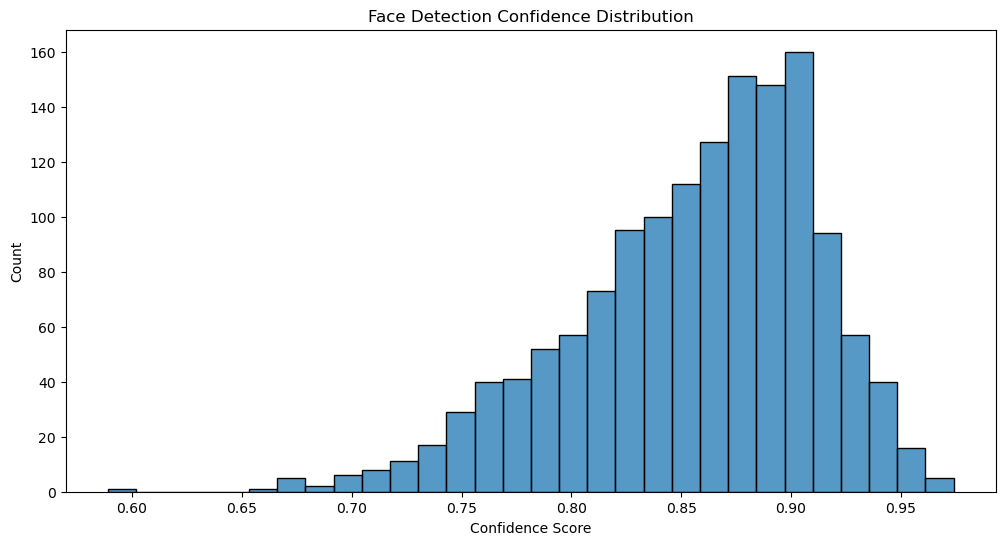

In [196]:
# 2. Face Detection Confidence Distribution
plt.figure(figsize=(12, 6))
face_conf = df['face_detection'].apply(lambda x: x['confidence'])
sns.histplot(data=face_conf, bins=30)
plt.title('Face Detection Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.show()

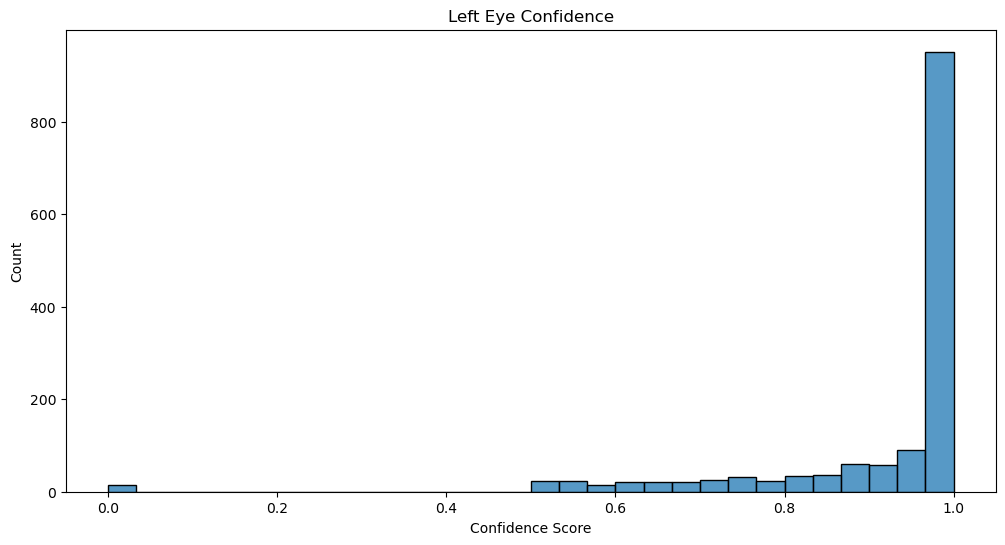

In [197]:
# 3. State Classification Confidence Analysis
plt.figure(figsize=(12, 6))
eye_conf_left = df['state_classification'].apply(lambda x: x['confidence_left'])

sns.histplot(data=eye_conf_left, bins=30)
plt.title('Left Eye Confidence')
plt.xlabel('Confidence Score')
plt.show()



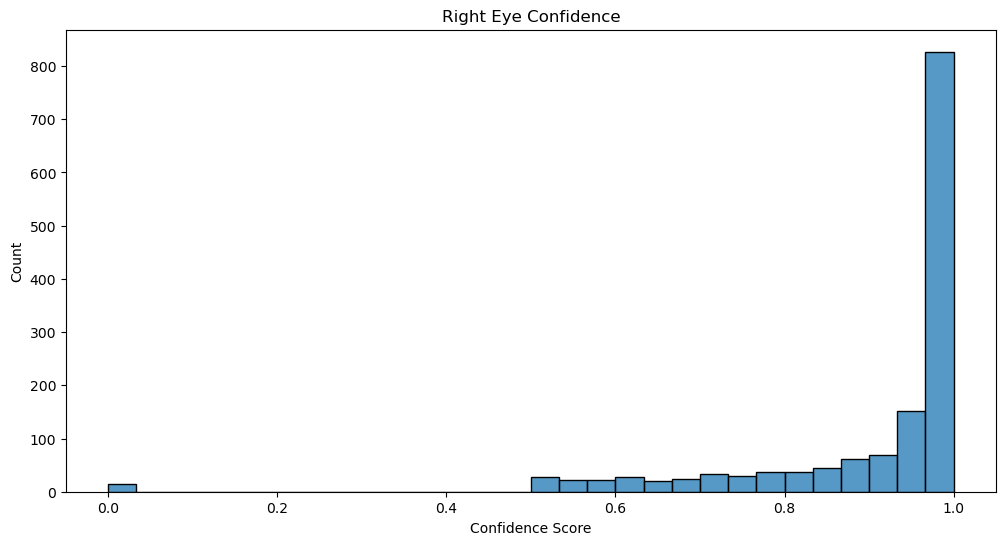

In [198]:
plt.figure(figsize=(12, 6))

eye_conf_right = df['state_classification'].apply(lambda x: x['confidence_right'])
sns.histplot(data=eye_conf_right, bins=30)
plt.title('Right Eye Confidence')
plt.xlabel('Confidence Score')
plt.show()



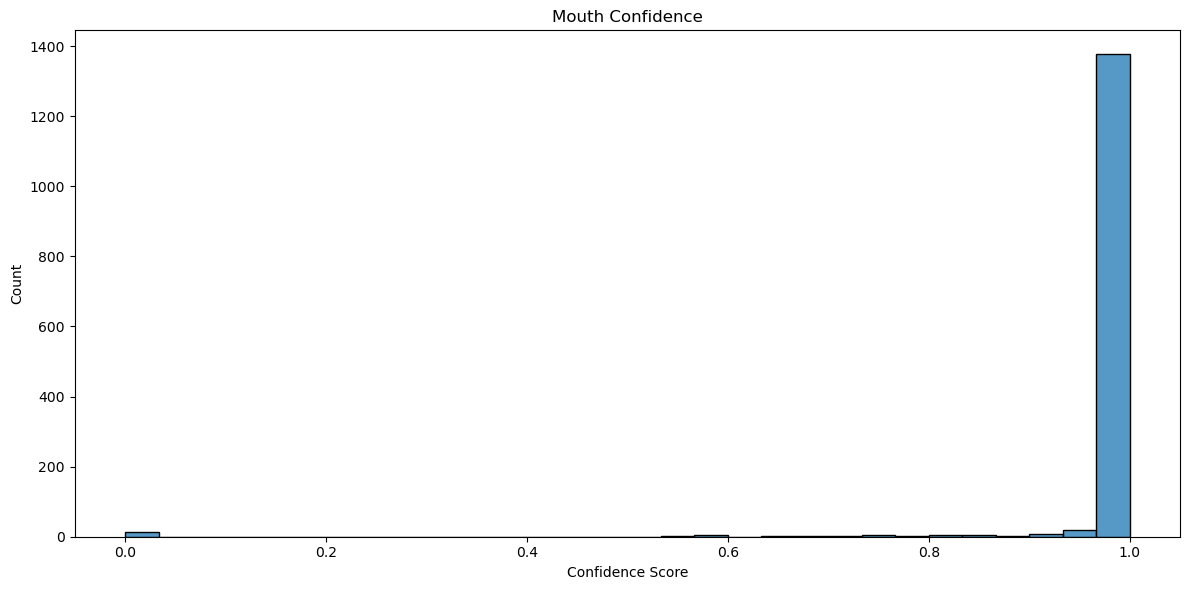

In [199]:
plt.figure(figsize=(12, 6))

mouth_conf = df['state_classification'].apply(lambda x: x['confidence_mouth'])
sns.histplot(data=mouth_conf, bins=30)
plt.title('Mouth Confidence')
plt.xlabel('Confidence Score')
plt.tight_layout()
plt.show()

In [224]:
# Confidence Calculation Analysis
def analyze_confidence_calculation(row):
    if not row['pipeline_success'] or not row['decision']['success']:
        return {
            'calculation_type': 'Failed',
            'raw_eye_conf': 0,
            'raw_mouth_conf': 0,
            'final_conf': 0
        }
    
    state_class = row['state_classification']
    decision = row['decision']
    
    # Calculate raw confidences
    eye_conf = (state_class['confidence_left'] + state_class['confidence_right']) / 2
    mouth_conf = state_class['confidence_mouth']
    
    # Determine calculation type based on decision factors
    if not decision['eye_status'] and not decision['yawn_status']:
        calc_type = 'Alert'
        final_conf = (eye_conf + mouth_conf) / 2
    elif decision['eye_status'] and decision['yawn_status']:
        calc_type = 'Both'
        final_conf = 0.6 * eye_conf + 0.4 * mouth_conf
    elif decision['eye_status']:
        calc_type = 'Eyes Only'
        final_conf = eye_conf
    elif decision['yawn_status']:
        calc_type = 'Yawn Only'
        final_conf = mouth_conf
    else:
        calc_type = 'Unknown'
        final_conf = 0.0
        
    return {
        'calculation_type': calc_type,
        'raw_eye_conf': eye_conf,
        'raw_mouth_conf': mouth_conf,
        'final_conf': final_conf
    }

# Apply the analysis
confidence_analysis = df.apply(analyze_confidence_calculation, axis=1)
df['confidence_calc_type'] = confidence_analysis.apply(lambda x: x['calculation_type'])
df['raw_eye_conf'] = confidence_analysis.apply(lambda x: x['raw_eye_conf'])
df['raw_mouth_conf'] = confidence_analysis.apply(lambda x: x['raw_mouth_conf'])
df['calculated_conf'] = confidence_analysis.apply(lambda x: x['final_conf'])

# Calculate accuracy
df['is_correct'] = df.apply(lambda row: 
    row['true_label'] == int(row['decision']['is_drowsy']) 
    if row['pipeline_success'] and row['decision']['is_drowsy'] is not None 
    else False, axis=1)

# Print comprehensive analysis
print("\n=== CONFIDENCE CALCULATION ANALYSIS ===")
print("\nOverall Statistics:")
print(f"Total samples: {len(df)}")
print(f"Overall accuracy: {df['is_correct'].mean():.3f}")

print("\nBreakdown by Calculation Type:")
for calc_type in df['confidence_calc_type'].unique():
    subset = df[df['confidence_calc_type'] == calc_type]
    print(f"\n{calc_type}:")
    print(f"Count: {len(subset)} ({len(subset)/len(df)*100:.1f}%)")
    if len(subset) > 0:
        print(f"Average Eye Confidence: {subset['raw_eye_conf'].mean():.3f}")
        print(f"Average Mouth Confidence: {subset['raw_mouth_conf'].mean():.3f}")
        print(f"Average Final Confidence: {subset['calculated_conf'].mean():.3f}")
        print(f"Accuracy: {subset['is_correct'].mean():.3f}")
        print(f"True Positives: {sum((subset['is_correct']) & (subset['decision'].apply(lambda x: x['is_drowsy'])))}")
        print(f"False Positives: {sum((~subset['is_correct']) & (subset['decision'].apply(lambda x: x['is_drowsy'])))}")


# Print high-confidence errors
print("\nHigh Confidence Errors (confidence > 0.8 but incorrect):")
high_conf_errors = df[(df['calculated_conf'] > 0.8) & (~df['is_correct'])]
if len(high_conf_errors) > 0:
    print(f"Number of high confidence errors: {len(high_conf_errors)}")
    print("\nBreakdown by calculation type:")
    print(high_conf_errors['confidence_calc_type'].value_counts())
else:
    print("No high confidence errors found")


=== CONFIDENCE CALCULATION ANALYSIS ===

Overall Statistics:
Total samples: 1448
Overall accuracy: 0.946

Breakdown by Calculation Type:

Both:
Count: 184 (12.7%)
Average Eye Confidence: 0.957
Average Mouth Confidence: 0.997
Average Final Confidence: 0.973
Accuracy: 0.995
True Positives: 183
False Positives: 1

Yawn Only:
Count: 504 (34.8%)
Average Eye Confidence: 0.907
Average Mouth Confidence: 0.999
Average Final Confidence: 0.999
Accuracy: 0.988
True Positives: 498
False Positives: 6

Eyes Only:
Count: 42 (2.9%)
Average Eye Confidence: 0.968
Average Mouth Confidence: 0.978
Average Final Confidence: 0.968
Accuracy: 0.143
True Positives: 6
False Positives: 36

Failed:
Count: 161 (11.1%)
Average Eye Confidence: 0.000
Average Mouth Confidence: 0.000
Average Final Confidence: 0.000
Accuracy: 0.795
True Positives: 0
False Positives: 0

Alert:
Count: 557 (38.5%)
Average Eye Confidence: 0.958
Average Mouth Confidence: 0.996
Average Final Confidence: 0.977
Accuracy: 0.996
True Positives: 0


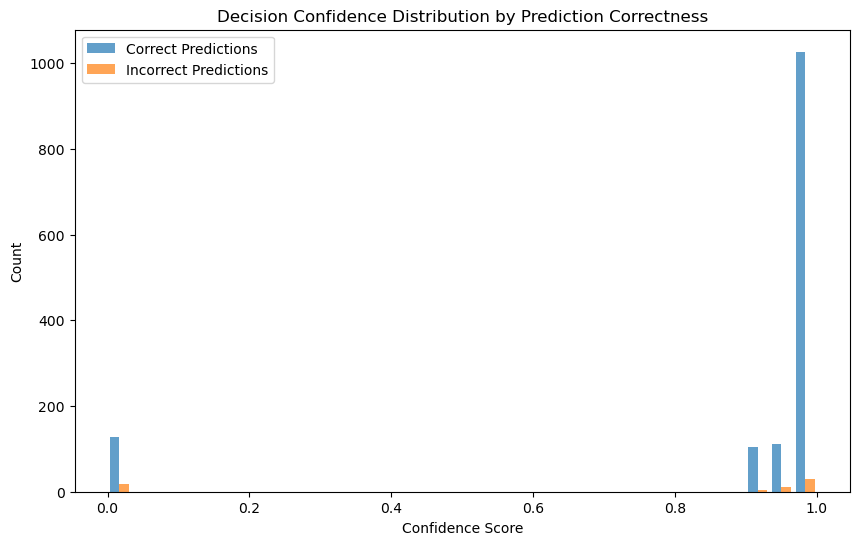

In [201]:
# 4. Decision Confidence vs Correctness
plt.figure(figsize=(10, 6))
correct_predictions = df[df.apply(lambda row: 
    row['true_label'] == int(row['decision']['is_drowsy']) 
    if row['pipeline_success'] and row['decision']['is_drowsy'] is not None 
    else False, axis=1)]
incorrect_predictions = df[df.apply(lambda row: 
    row['true_label'] != int(row['decision']['is_drowsy']) 
    if row['pipeline_success'] and row['decision']['is_drowsy'] is not None 
    else False, axis=1)]

plt.hist([
    correct_predictions['decision'].apply(lambda x: x['confidence']),
    incorrect_predictions['decision'].apply(lambda x: x['confidence'])
], label=['Correct Predictions', 'Incorrect Predictions'], bins=30, alpha=0.7)
plt.title('Decision Confidence Distribution by Prediction Correctness')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.legend()
plt.show()

In [202]:
# 5. Error Analysis Summary
error_analysis = {
    'total_images': len(df),
    'face_detection_failures': len(df[~df['face_detection'].apply(lambda x: x['success'])]),
    'feature_extraction_failures': len(df[~df['feature_extraction'].apply(lambda x: x['success'])]),
    'pipeline_failures': len(df[~df['pipeline_success']]),
    'classification_failures': len(df[df.apply(lambda row: 
        row['true_label'] != int(row['decision']['is_drowsy']) 
        if row['pipeline_success'] and row['decision']['is_drowsy'] is not None 
        else False, axis=1)])
}
# Print error analysis
print("\nError Analysis Summary:")
for key, value in error_analysis.items():
    print(f"{key}: {value}")


Error Analysis Summary:
total_images: 1448
face_detection_failures: 0
feature_extraction_failures: 14
pipeline_failures: 14
classification_failures: 64


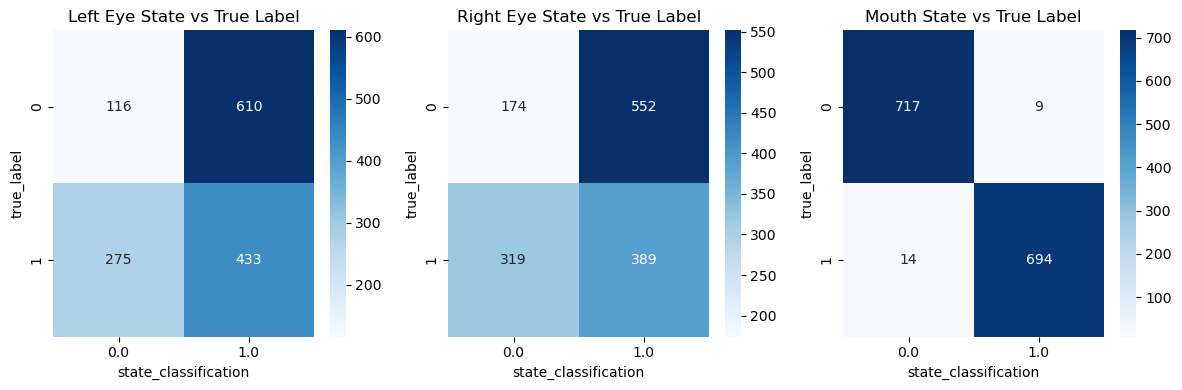

In [203]:
# 6. Confusion Matrix for State Classification
plt.figure(figsize=(12, 4))

# Left Eye
plt.subplot(1, 3, 1)
left_eye_true = df['true_label']
left_eye_pred = df['state_classification'].apply(lambda x: x['left_eye_state'])
sns.heatmap(pd.crosstab(left_eye_true, left_eye_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Left Eye State vs True Label')

# Right Eye
plt.subplot(1, 3, 2)
right_eye_pred = df['state_classification'].apply(lambda x: x['right_eye_state'])
sns.heatmap(pd.crosstab(left_eye_true, right_eye_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Right Eye State vs True Label')

# Mouth
plt.subplot(1, 3, 3)
mouth_pred = df['state_classification'].apply(lambda x: x['mouth_state'])
sns.heatmap(pd.crosstab(left_eye_true, mouth_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Mouth State vs True Label')

plt.tight_layout()
plt.show()

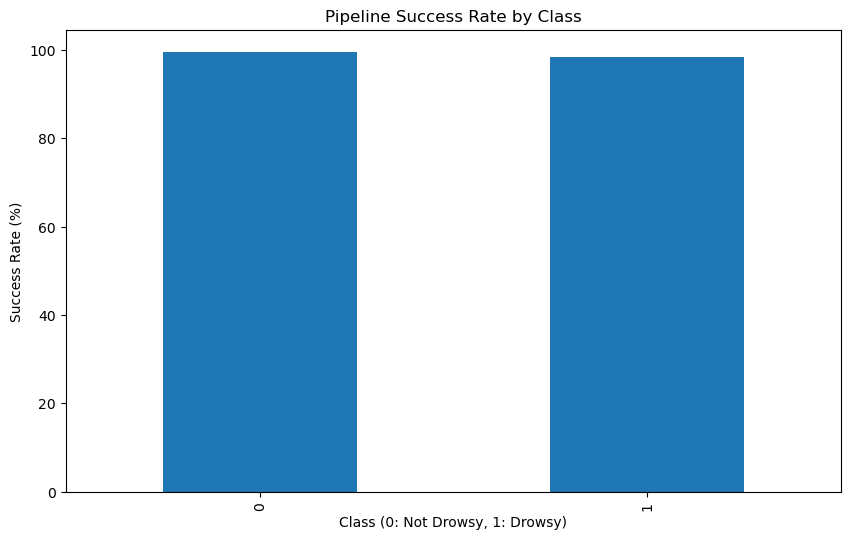

true_label
0    99.588477
1    98.470097
Name: pipeline_success, dtype: float64


In [204]:
# 7. Success Rate by Class
plt.figure(figsize=(10, 6))
success_by_class = df.groupby('true_label')['pipeline_success'].mean() * 100
success_by_class.plot(kind='bar')
plt.title('Pipeline Success Rate by Class')
plt.xlabel('Class (0: Not Drowsy, 1: Drowsy)')
plt.ylabel('Success Rate (%)')
plt.show()
print(success_by_class)

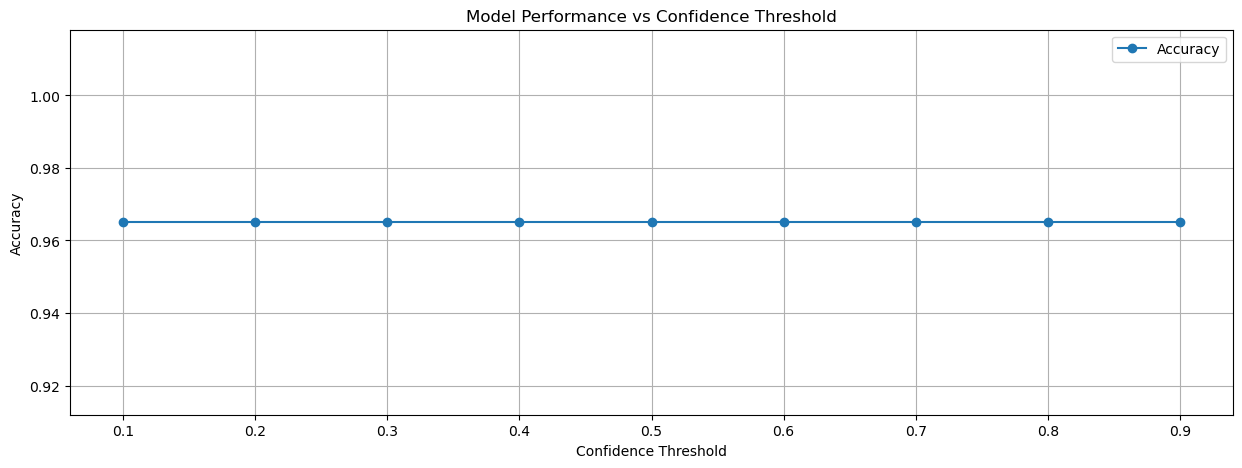

In [205]:
# 8. Confidence Threshold Analysis
plt.figure(figsize=(15, 5))

# Create confidence thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
accuracies = []
precisions = []
recalls = []

for threshold in thresholds:
    # Filter predictions based on confidence threshold
    high_conf_preds = df[df['decision'].apply(lambda x: x['confidence'] >= threshold)]
    
    # Calculate metrics
    correct = high_conf_preds.apply(lambda row: 
        row['true_label'] == int(row['decision']['is_drowsy']) 
        if row['pipeline_success'] and row['decision']['is_drowsy'] is not None 
        else False, axis=1)
    
    accuracies.append(correct.mean())
    
plt.plot(thresholds, accuracies, marker='o', label='Accuracy')
plt.title('Model Performance vs Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [206]:
# 9. Error Analysis by Image Path
# Extract relevant information for failed cases
failed_cases = df[~df['pipeline_success']].copy()
failed_cases['failure_type'] = failed_cases.apply(lambda row: 
    'Face Detection' if not row['face_detection']['success'] 
    else 'Feature Extraction' if not row['feature_extraction']['success']
    else 'Decision Logic', axis=1)

print("\nDetailed Error Analysis:")
print(failed_cases[['image_path', 'failure_type']].head())


Detailed Error Analysis:
                                            image_path        failure_type
116  /Users/ahmedalkhulayfi/Downloads/Roboflow_data...  Feature Extraction
169  /Users/ahmedalkhulayfi/Downloads/Roboflow_data...  Feature Extraction
228  /Users/ahmedalkhulayfi/Downloads/Roboflow_data...  Feature Extraction
243  /Users/ahmedalkhulayfi/Downloads/Roboflow_data...  Feature Extraction
257  /Users/ahmedalkhulayfi/Downloads/Roboflow_data...  Feature Extraction


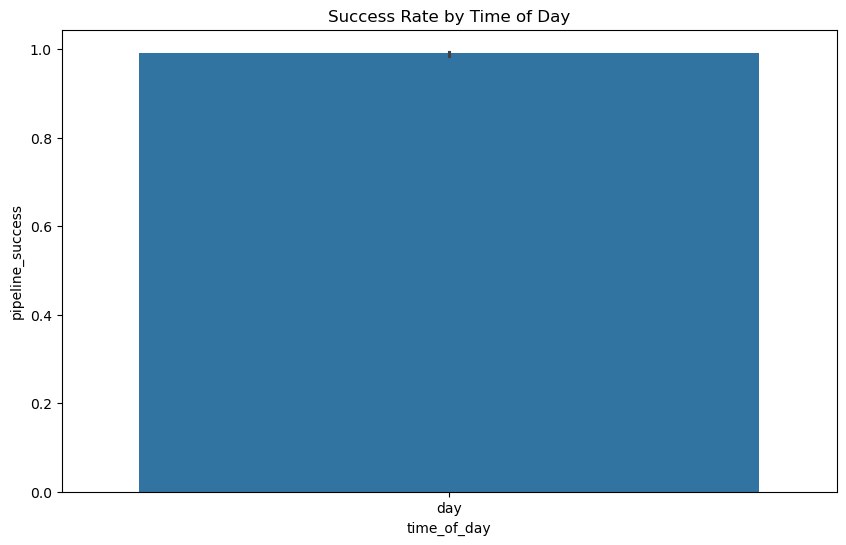

In [207]:
# 10. Time of Day Analysis (if timestamps are in image paths)
def extract_time_info(path):
    # Modify this based on your image naming convention
    return 'day'  # placeholder

df['time_of_day'] = df['image_path'].apply(extract_time_info)
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='time_of_day', y='pipeline_success')
plt.title('Success Rate by Time of Day')
plt.show()

/var/folders/jc/gg0g8k9x0n1cj1b8d04f93p80000gn/T/ipykernel_13893/3579715013.py:10: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  eye_states.apply(pd.value_counts).plot(kind='bar')


Text(0, 0.5, 'Count')

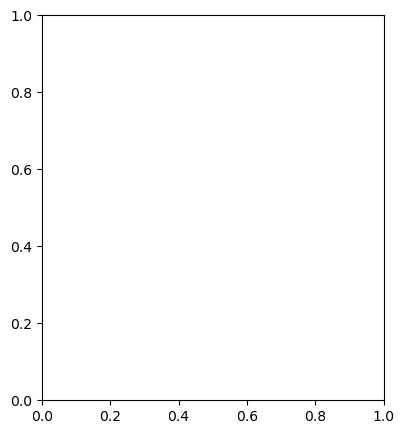

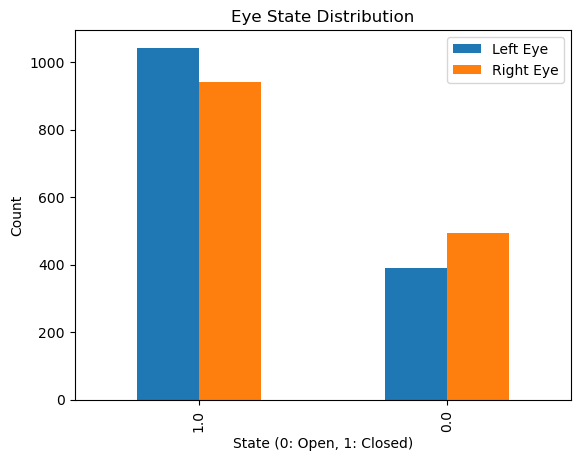

In [208]:
# 11. Feature State Distribution
plt.figure(figsize=(15, 5))

# Eye States
plt.subplot(1, 3, 1)
eye_states = pd.DataFrame({
    'Left Eye': df['state_classification'].apply(lambda x: x['left_eye_state']),
    'Right Eye': df['state_classification'].apply(lambda x: x['right_eye_state'])
})
eye_states.apply(pd.value_counts).plot(kind='bar')
plt.title('Eye State Distribution')
plt.xlabel('State (0: Open, 1: Closed)')
plt.ylabel('Count')

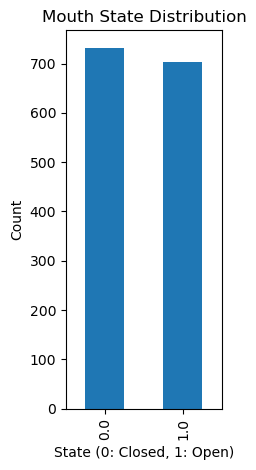

In [209]:
# Mouth State
plt.subplot(1, 3, 2)
mouth_states = df['state_classification'].apply(lambda x: x['mouth_state'])
pd.Series(mouth_states).value_counts().plot(kind='bar')
plt.title('Mouth State Distribution')
plt.xlabel('State (0: Closed, 1: Open)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

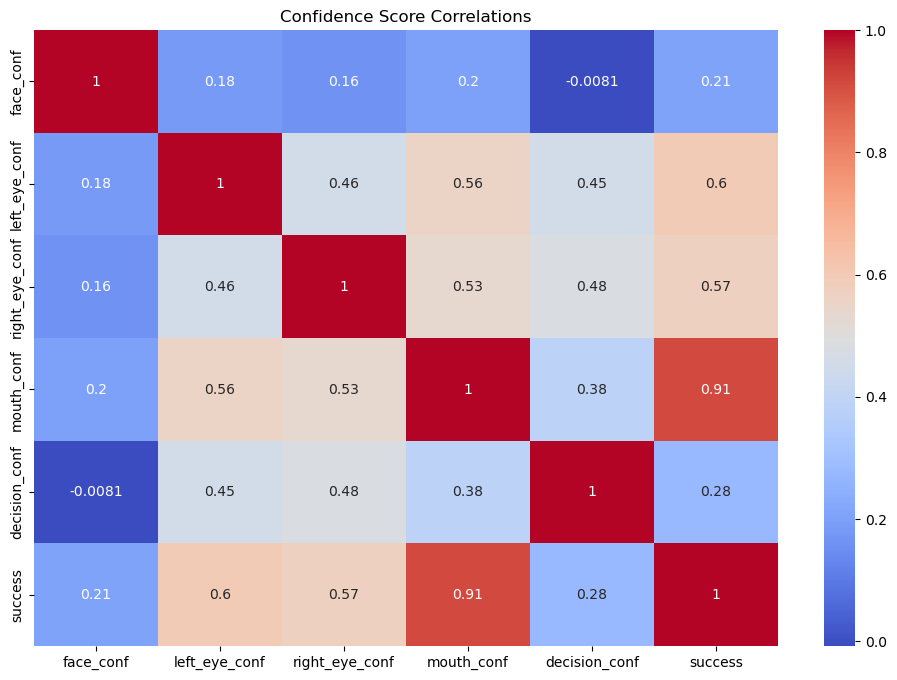

In [210]:
# 12. Correlation Analysis
plt.figure(figsize=(12, 8))
correlation_data = pd.DataFrame({
    'face_conf': df['face_detection'].apply(lambda x: x['confidence']),
    'left_eye_conf': df['state_classification'].apply(lambda x: x['confidence_left']),
    'right_eye_conf': df['state_classification'].apply(lambda x: x['confidence_right']),
    'mouth_conf': df['state_classification'].apply(lambda x: x['confidence_mouth']),
    'decision_conf': df['decision'].apply(lambda x: x['confidence']),
    'success': df['pipeline_success']
})

sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm')
plt.title('Confidence Score Correlations')
plt.show()


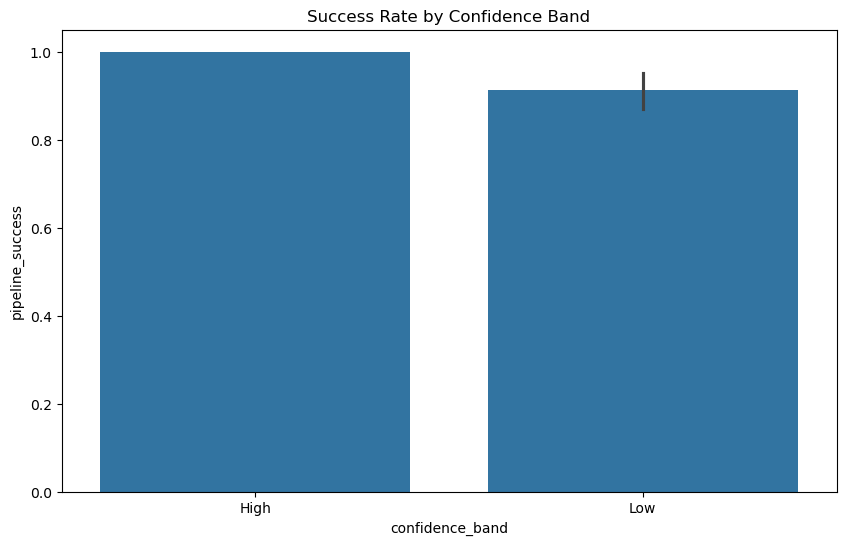

In [211]:
# 13. Performance by Confidence Bands
def get_confidence_band(conf):
    if conf < 0.6: return 'Low'
    elif conf < 0.8: return 'Medium'
    else: return 'High'

df['confidence_band'] = df['decision'].apply(lambda x: get_confidence_band(x['confidence']))
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='confidence_band', y='pipeline_success')
plt.title('Success Rate by Confidence Band')
plt.show()

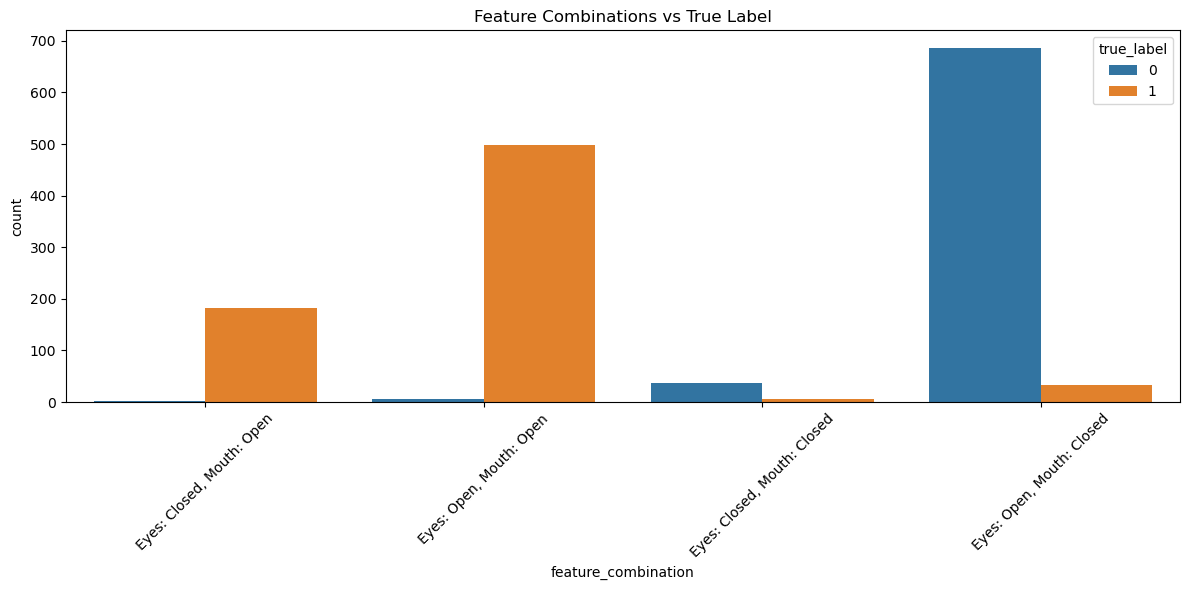

In [212]:
#14. Multi-feature Analysis
plt.figure(figsize=(12, 6))
df['feature_combination'] = df.apply(lambda row: 
    f"Eyes: {'Closed' if row['decision']['eye_status'] else 'Open'}, "
    f"Mouth: {'Open' if row['decision']['yawn_status'] else 'Closed'}", axis=1)

sns.countplot(data=df, x='feature_combination', hue='true_label')
plt.xticks(rotation=45)
plt.title('Feature Combinations vs True Label')
plt.tight_layout()
plt.show()

Face Detection        1.000000
Feature Extraction    0.990331
Decision Success      0.888812
dtype: float64


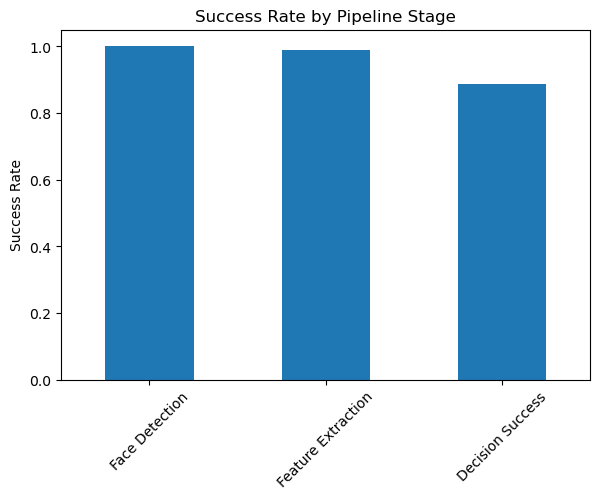

In [213]:
# 15. Pipeline Stage Analysis
plt.figure(figsize=(15, 10))

# Stage Success Analysis
stage_success = pd.DataFrame({
    'Face Detection': df['face_detection'].apply(lambda x: x['success']),
    'Feature Extraction': df['feature_extraction'].apply(lambda x: x['success']),
    'Decision Success': df['decision'].apply(lambda x: x['success'])
})

plt.subplot(2, 2, 1)
stage_success.mean().plot(kind='bar')
plt.title('Success Rate by Pipeline Stage')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
print(stage_success.mean())

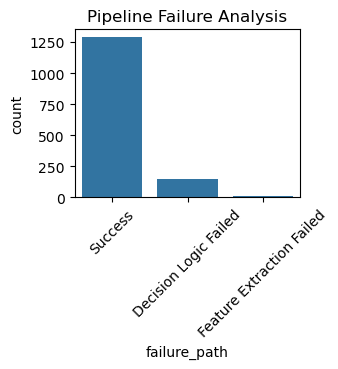

In [214]:
# 16. Failure Path Analysis
def analyze_failure_path(row):
    if not row['face_detection']['success']:
        return 'Face Detection Failed'
    elif not row['feature_extraction']['success']:
        return 'Feature Extraction Failed'
    elif not row['decision']['success']:
        return 'Decision Logic Failed'
    return 'Success'

df['failure_path'] = df.apply(analyze_failure_path, axis=1)
plt.subplot(2, 2, 2)
sns.countplot(data=df, x='failure_path')
plt.xticks(rotation=45)
plt.title('Pipeline Failure Analysis')
plt.show()

In [215]:
# 18. Edge Case Analysis
edge_cases = df[
    (df['face_detection'].apply(lambda x: x['confidence'] < 0.6)) |  # Low face confidence
    (df['state_classification'].apply(lambda x: x['confidence_left'] < 0.6)) |  # Low eye confidence
    (df['state_classification'].apply(lambda x: x['confidence_right'] < 0.6)) |
    (df['state_classification'].apply(lambda x: x['confidence_mouth'] < 0.6))    # Low mouth confidence
]

print("\nEdge Cases Analysis:")
print(f"Total edge cases: {len(edge_cases)}")
print("\nEdge case success rate:", edge_cases['pipeline_success'].mean())


Edge Cases Analysis:
Total edge cases: 151

Edge case success rate: 0.9072847682119205


([0, 1, 2],
 [Text(0, 0, 'Both Open'), Text(1, 0, 'Both Closed'), Text(2, 0, 'Mixed')])

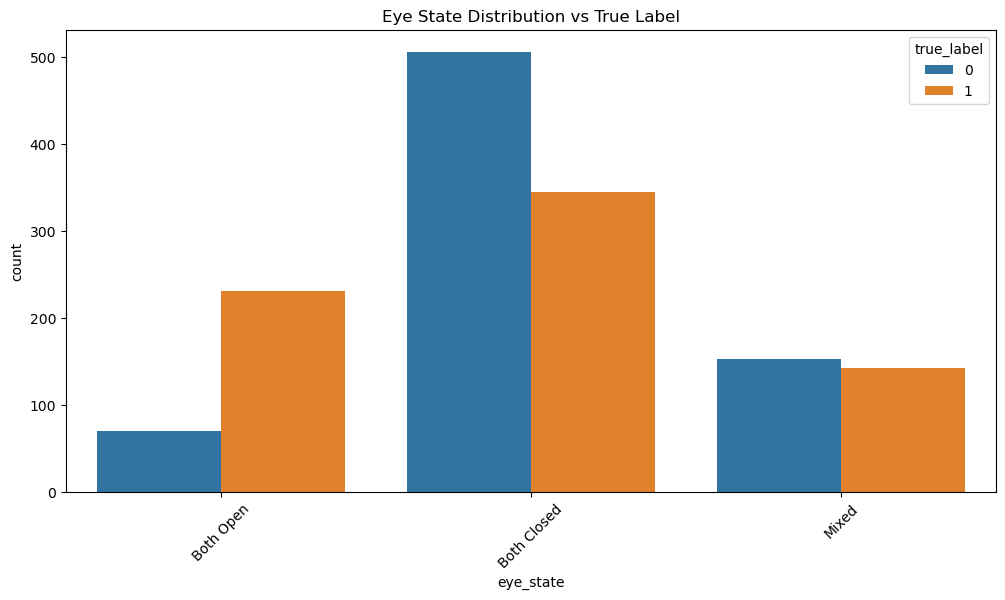

In [216]:
# 19. State Transition Analysis
df['eye_state'] = df['state_classification'].apply(
    lambda x: 'Both Open' if x['left_eye_state'] == 0 and x['right_eye_state'] == 0
    else 'Both Closed' if x['left_eye_state'] == 1 and x['right_eye_state'] == 1
    else 'Mixed'
)

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='eye_state', hue='true_label')
plt.title('Eye State Distribution vs True Label')
plt.xticks(rotation=45)


([0, 1, 2, 3],
 [Text(0, 0, 'Eyes: Closed, Yawn: Yes'),
  Text(1, 0, 'Eyes: Open, Yawn: Yes'),
  Text(2, 0, 'Eyes: Closed, Yawn: No'),
  Text(3, 0, 'Eyes: Open, Yawn: No')])

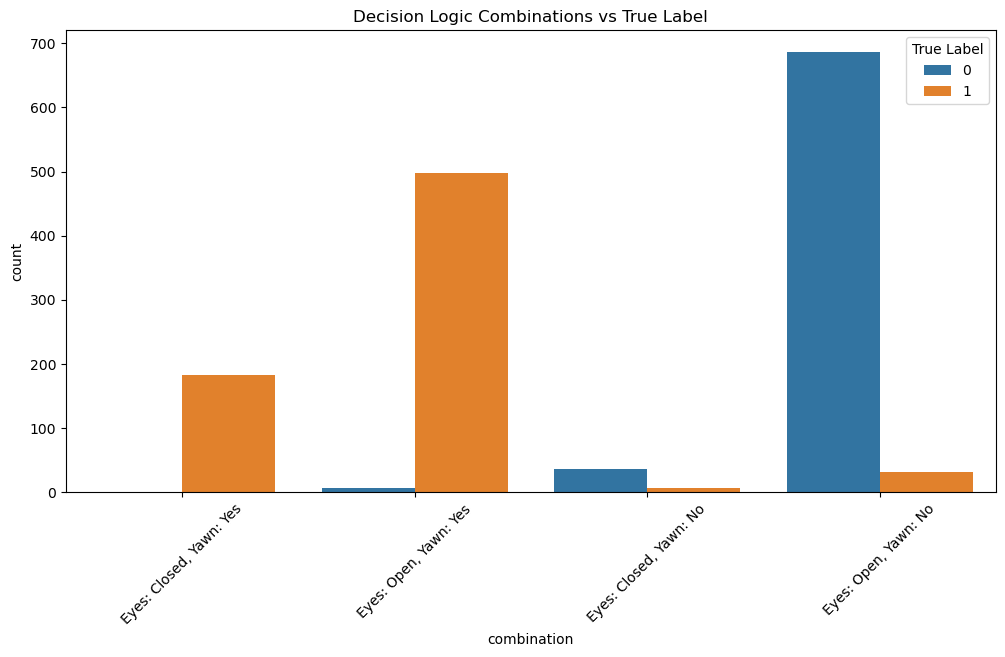

In [217]:
# 20. Decision Logic Analysis
plt.figure(figsize=(12, 6))
decision_analysis = pd.DataFrame({
    'Eye Status': df['decision'].apply(lambda x: x['eye_status']),
    'Yawn Status': df['decision'].apply(lambda x: x['yawn_status']),
    'Is Drowsy': df['decision'].apply(lambda x: x['is_drowsy']),
    'True Label': df['true_label']
})

# Create decision combinations
decision_analysis['combination'] = decision_analysis.apply(
    lambda x: f"Eyes: {'Closed' if x['Eye Status'] else 'Open'}, "
              f"Yawn: {'Yes' if x['Yawn Status'] else 'No'}", axis=1
)

sns.countplot(data=decision_analysis, x='combination', hue='True Label')
plt.title('Decision Logic Combinations vs True Label')
plt.xticks(rotation=45)

In [218]:
# 21. Misclassification Analysis
misclassified = df[df.apply(lambda row: 
    row['true_label'] != int(row['decision']['is_drowsy']) 
    if row['pipeline_success'] and row['decision']['is_drowsy'] is not None 
    else False, axis=1)]

print("\nMisclassification Analysis:")
print(f"Total misclassifications: {len(misclassified)}")
print("\nAverage confidence scores for misclassified cases:")
print("Face Detection:", misclassified['face_detection'].apply(lambda x: x['confidence']).mean())
print("Left Eye:", misclassified['state_classification'].apply(lambda x: x['confidence_left']).mean())
print("Right Eye:", misclassified['state_classification'].apply(lambda x: x['confidence_right']).mean())
print("Mouth:", misclassified['state_classification'].apply(lambda x: x['confidence_mouth']).mean())


Misclassification Analysis:
Total misclassifications: 64

Average confidence scores for misclassified cases:
Face Detection: 0.8515588827431202
Left Eye: 0.9302024412900209
Right Eye: 0.9228132031857967
Mouth: 0.9490442220121622


Text(0.5, 1.0, 'Eye State Symmetry vs True Label')

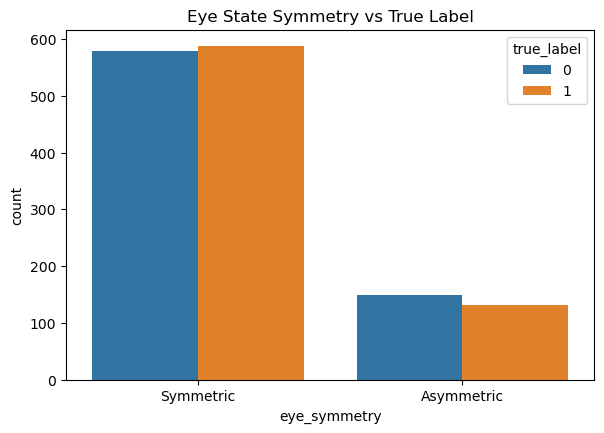

In [219]:
# 23. Detailed Feature Analysis
plt.figure(figsize=(15, 10))

# Analyze eye state symmetry
df['eye_symmetry'] = df['state_classification'].apply(
    lambda x: 'Symmetric' if x['left_eye_state'] == x['right_eye_state'] else 'Asymmetric'
)

plt.subplot(2, 2, 1)
sns.countplot(data=df, x='eye_symmetry', hue='true_label')
plt.title('Eye State Symmetry vs True Label')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Low Face Confidence'),
  Text(1, 0, 'Asymmetric Eyes'),
  Text(2, 0, 'Low Eye Confidence'),
  Text(3, 0, 'Low Mouth Confidence')])

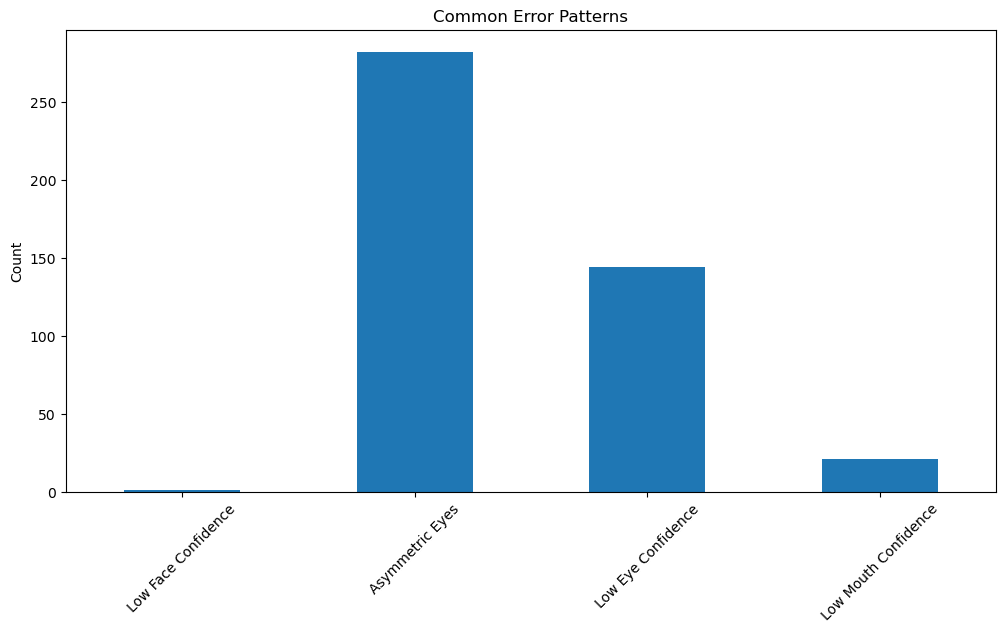

In [220]:
# 27. Error Pattern Analysis
error_patterns = pd.DataFrame({
    'Low Face Confidence': df['face_detection'].apply(lambda x: x['confidence'] < 0.6),
    'Asymmetric Eyes': df['eye_symmetry'] == 'Asymmetric',
    'Low Eye Confidence': df['state_classification'].apply(
        lambda x: min(x['confidence_left'], x['confidence_right']) < 0.6
    ),
    'Low Mouth Confidence': df['state_classification'].apply(lambda x: x['confidence_mouth'] < 0.6)
})

plt.figure(figsize=(12, 6))
error_patterns.sum().plot(kind='bar')
plt.title('Common Error Patterns')
plt.ylabel('Count')
plt.xticks(rotation=45)

([0, 1, 2, 3],
 [Text(0, 0, 'Face Detection'),
  Text(1, 0, 'Left Eye'),
  Text(2, 0, 'Right Eye'),
  Text(3, 0, 'Mouth')])

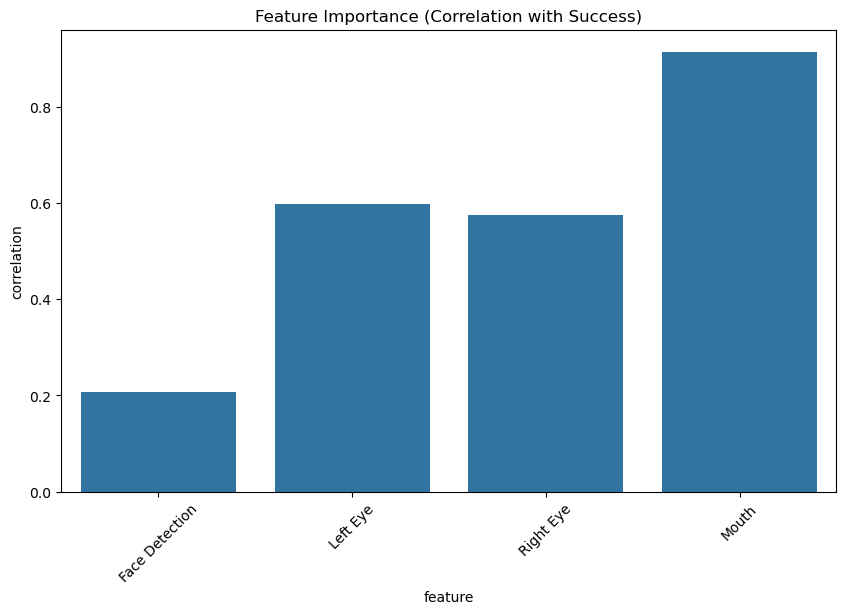

In [221]:
# 29. Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': ['Face Detection', 'Left Eye', 'Right Eye', 'Mouth'],
    'correlation': [
        df['face_detection'].apply(lambda x: x['confidence']).corr(df['pipeline_success']),
        df['state_classification'].apply(lambda x: x['confidence_left']).corr(df['pipeline_success']),
        df['state_classification'].apply(lambda x: x['confidence_right']).corr(df['pipeline_success']),
        df['state_classification'].apply(lambda x: x['confidence_mouth']).corr(df['pipeline_success'])
    ]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='feature', y='correlation')
plt.title('Feature Importance (Correlation with Success)')
plt.xticks(rotation=45)


/var/folders/jc/gg0g8k9x0n1cj1b8d04f93p80000gn/T/ipykernel_13893/3114321423.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  factor_accuracy = df.groupby('drowsy_factor').apply(



Accuracy by Decision Factor:
drowsy_factor
Both (Eyes + Yawning)    0.994565
Eyes Only                0.142857
Not Drowsy               0.996409
Pipeline Failed          0.813665
Yawning Only             0.988095
dtype: float64

Detailed Statistics by Decision Factor:
                       Success Rate  Count
drowsy_factor                             
Both (Eyes + Yawning)      1.000000    184
Eyes Only                  1.000000     42
Not Drowsy                 1.000000    557
Pipeline Failed            0.913043    161
Yawning Only               1.000000    504


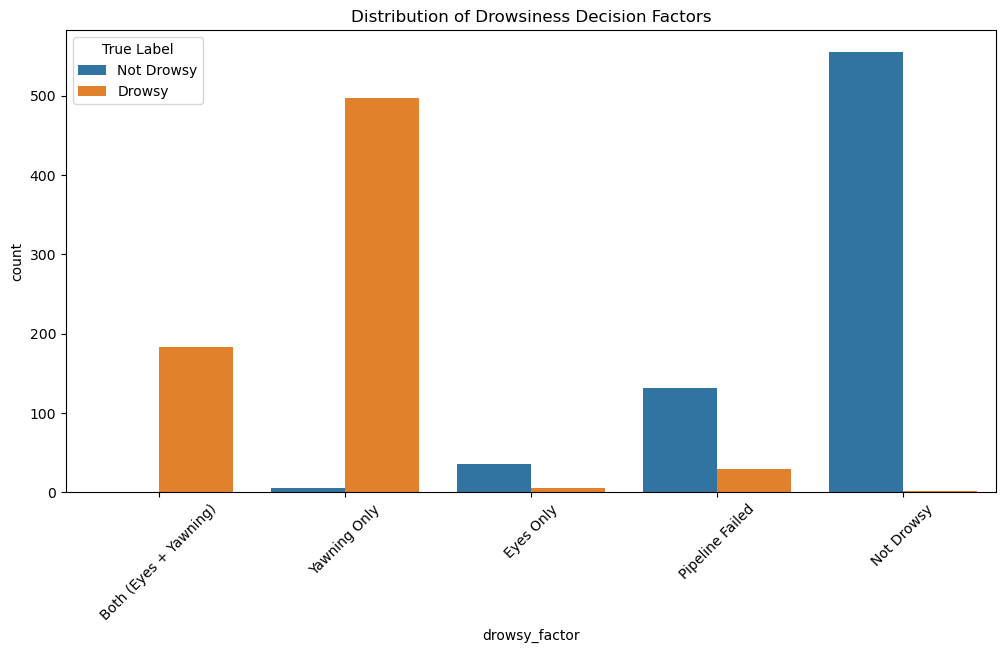

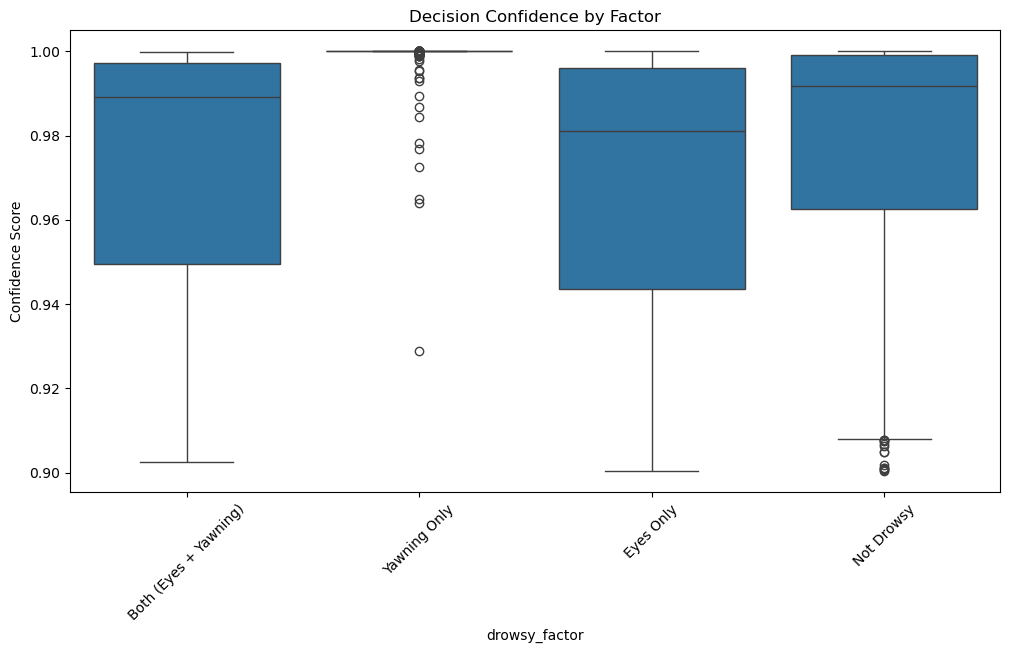

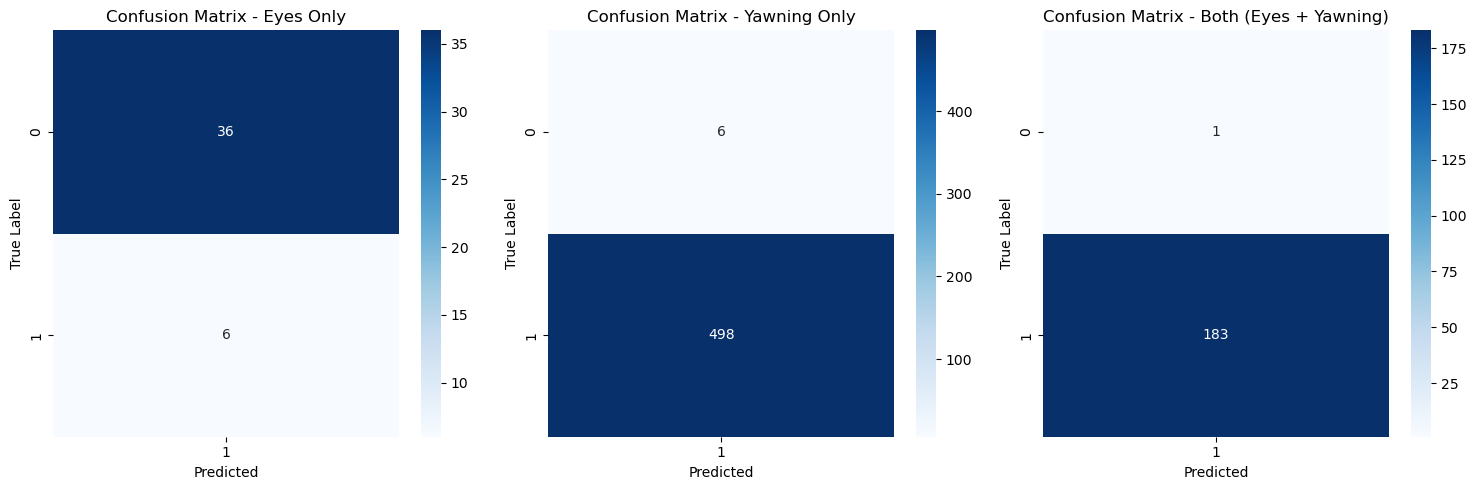

<Figure size 1500x600 with 0 Axes>

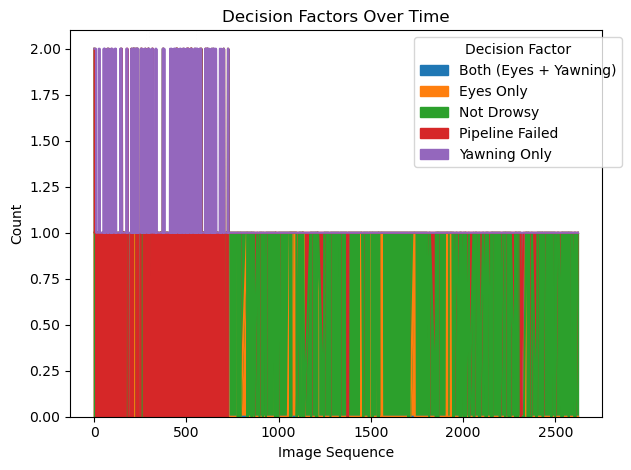

In [222]:
# 31. Decision Factor Analysis
def get_drowsy_factor(row):
    if not row['pipeline_success'] or not row['decision']['success']:
        return 'Pipeline Failed'
    if row['decision']['is_drowsy']:
        if row['decision']['eye_status'] and row['decision']['yawn_status']:
            return 'Both (Eyes + Yawning)'
        elif row['decision']['eye_status']:
            return 'Eyes Only'
        elif row['decision']['yawn_status']:
            return 'Yawning Only'
        else:
            return 'Unknown Factor'
    return 'Not Drowsy'

# Add drowsy factor to dataframe
df['drowsy_factor'] = df.apply(get_drowsy_factor, axis=1)

# Plot the distribution of drowsy factors
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='drowsy_factor', hue='true_label')
plt.title('Distribution of Drowsiness Decision Factors')
plt.xticks(rotation=45)
plt.legend(title='True Label', labels=['Not Drowsy', 'Drowsy'])

# Calculate accuracy for each factor
factor_accuracy = df.groupby('drowsy_factor').apply(
    lambda x: (x['true_label'] == x['decision'].apply(
        lambda d: int(d['is_drowsy']) if d['success'] else 0
    )).mean()
)

print("\nAccuracy by Decision Factor:")
print(factor_accuracy)

# Confidence analysis by factor
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['drowsy_factor'] != 'Pipeline Failed'], 
            x='drowsy_factor', 
            y=df['decision'].apply(lambda x: x['confidence']))
plt.title('Decision Confidence by Factor')
plt.xticks(rotation=45)
plt.ylabel('Confidence Score')

# Detailed statistics for each factor
factor_stats = df.groupby('drowsy_factor').agg({
    'pipeline_success': 'mean',
    'true_label': 'count'
}).rename(columns={
    'pipeline_success': 'Success Rate',
    'true_label': 'Count'
})

print("\nDetailed Statistics by Decision Factor:")
print(factor_stats)

# Confusion matrix for each factor
plt.figure(figsize=(15, 5))
factors = ['Eyes Only', 'Yawning Only', 'Both (Eyes + Yawning)']

for i, factor in enumerate(factors, 1):
    plt.subplot(1, 3, i)
    factor_data = df[df['drowsy_factor'] == factor]
    cm = pd.crosstab(
        factor_data['true_label'],
        factor_data['decision'].apply(lambda x: int(x['is_drowsy']))
    )
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {factor}')
    plt.xlabel('Predicted')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Time series analysis of factors (if images are sequential)
df['image_number'] = df['image_path'].apply(
    lambda x: int(x.split('/')[-1].split('_')[0])
)

plt.figure(figsize=(15, 6))
factor_counts = df.groupby(['image_number', 'drowsy_factor']).size().unstack(fill_value=0)
factor_counts.plot(kind='area', stacked=True)
plt.title('Decision Factors Over Time')
plt.xlabel('Image Sequence')
plt.ylabel('Count')
plt.legend(title='Decision Factor', bbox_to_anchor=(1.05, 1))
plt.tight_layout()